In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [14]:
# Load the data
data = pd.read_json('dataset.json')
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [15]:
data.shape

(26709, 3)

In [26]:
# Split the data into training and testing sets
train = data.headline
labels = data.is_sarcastic

In [27]:
# Parameters
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = 'unknown'

In [28]:
# Prprocess the data
# Tokenize the data
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)

tokenizer.fit_on_texts(train)
word_index = tokenizer.word_index

# Pad the sequences
train_sequences = tokenizer.texts_to_sequences(train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

train_padded.shape

(26709, 100)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(train_padded, labels, test_size=0.2, random_state=45)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((21367, 100), (21367,), (5342, 100), (5342,))

In [33]:
# Build the model
model = Sequential([
    layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    layers.GlobalAveragePooling1D(),
    layers.Dense(24, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1  (None, 16)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160433 (626.69 KB)
Trainable params: 160433 (626.69 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), verbose=2)  

Epoch 1/30
668/668 - 4s - loss: 0.4672 - accuracy: 0.8077 - val_loss: 0.3944 - val_accuracy: 0.8362 - 4s/epoch - 5ms/step
Epoch 2/30
668/668 - 3s - loss: 0.3168 - accuracy: 0.8749 - val_loss: 0.3501 - val_accuracy: 0.8499 - 3s/epoch - 4ms/step
Epoch 3/30
668/668 - 2s - loss: 0.2629 - accuracy: 0.8976 - val_loss: 0.3379 - val_accuracy: 0.8594 - 2s/epoch - 4ms/step
Epoch 4/30
668/668 - 2s - loss: 0.2269 - accuracy: 0.9142 - val_loss: 0.3402 - val_accuracy: 0.8575 - 2s/epoch - 4ms/step
Epoch 5/30
668/668 - 2s - loss: 0.2024 - accuracy: 0.9223 - val_loss: 0.3491 - val_accuracy: 0.8559 - 2s/epoch - 4ms/step
Epoch 6/30
668/668 - 2s - loss: 0.1799 - accuracy: 0.9318 - val_loss: 0.3494 - val_accuracy: 0.8589 - 2s/epoch - 4ms/step
Epoch 7/30
668/668 - 2s - loss: 0.1629 - accuracy: 0.9407 - val_loss: 0.3629 - val_accuracy: 0.8562 - 2s/epoch - 4ms/step
Epoch 8/30
668/668 - 2s - loss: 0.1487 - accuracy: 0.9470 - val_loss: 0.3763 - val_accuracy: 0.8549 - 2s/epoch - 4ms/step
Epoch 9/30
668/668 - 2s 

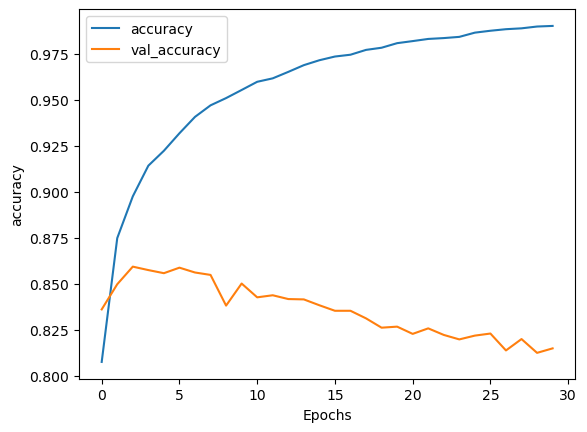

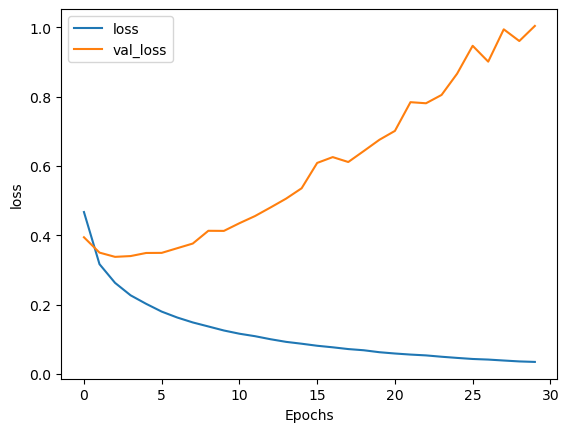

In [37]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [41]:
not_sarcasm = "Oh, because I definitely needed another email from that company I bought one thing from six years ago."
sarcasm = "I love it when my computer freezes up and I have to restart it."

# Predictions
def predict_sarcasm(sentence):
  sequences = tokenizer.texts_to_sequences([sentence])
  padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
  return model.predict(padded)

print(predict_sarcasm(not_sarcasm))
print(predict_sarcasm(sarcasm))

1/1 [==============================] - 0s 51ms/step
[[0.41894758]]
1/1 [==============================] - 0s 37ms/step
[[1.3387806e-08]]


In [42]:
# Get the index-word dictionary
reverse_word_index = tokenizer.index_word

# Get the embedding layer from the model (i.e. first layer)
embedding_layer = model.layers[0]

# Get the weights of the embedding layer
embedding_weights = embedding_layer.get_weights()[0]

# Print the shape. Expected is (vocab_size, embedding_dim)
print(embedding_weights.shape) 


(10000, 16)


In [44]:
import io

# Open writeable files
out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')

# Initialize the loop. Start counting at `1` because `0` is just for the padding
for word_num in range(2, vocab_size):

  # Get the word associated at the current index
  word_name = reverse_word_index[word_num]

  # Get the embedding weights associated with the current index
  word_embedding = embedding_weights[word_num]

  # Write the word name
  out_m.write(word_name + "\n")

  # Write the word embedding
  out_v.write('\t'.join([str(x) for x in word_embedding]) + "\n")

# Close the files
out_v.close()
out_m.close()

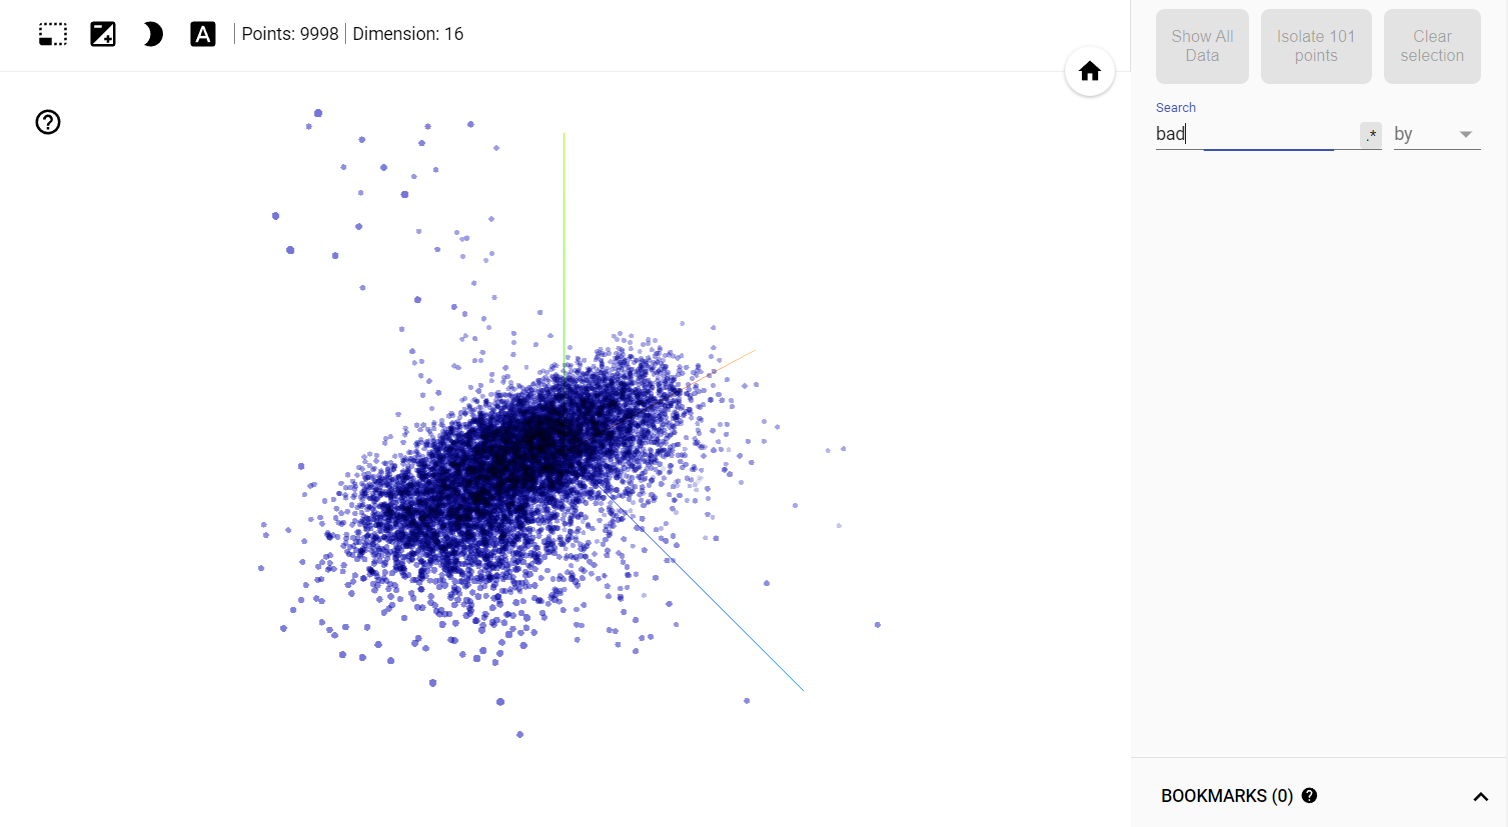